In [1]:
import pytest
import torch
from torch import einsum, nn
import triton
import triton.language as tl
from triton_testing.multihead_attention import multihead_flash_attention
from triton_testing.multiquery_attention import multiquery_flash_attention
from triton_testing.query_norm import fused_query_norm, naive_query_norm
from triton_testing.fused_multiquery_querynorm import multiquery_querynorm_flash_attention

## Multiquery Attention

The following blocks compare a triton implementation of multiquery attention with a baseline flashattention implementation (keys and values are repeated on all heads to get equivalent outputs from flashattention)

In [2]:
def test_multiquery_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float16):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    dout = torch.randn_like(q)
    # triton implementation
    tri_out = multiquery_flash_attention(q, k, v)
    tri_out.backward(dout)
    tri_dv, v.grad = v.grad.clone(), None
    tri_dk, k.grad = k.grad.clone(), None
    tri_dq, q.grad = q.grad.clone(), None
    # reference implementation
    reshaped_k = k.reshape(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    reshaped_v = v.reshape(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    ref_out = multihead_flash_attention(q,reshaped_k,reshaped_v)
    ref_out.backward(dout)
    ref_dv, v.grad = v.grad.clone(), None
    ref_dk, k.grad = k.grad.clone(), None
    ref_dq, q.grad = q.grad.clone(), None
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)
    triton.testing.assert_almost_equal(ref_dq, tri_dq)
    triton.testing.assert_almost_equal(ref_dk, tri_dk)
    triton.testing.assert_almost_equal(ref_dv, tri_dv)
    print("Passed all equality checks")

In [3]:
test_multiquery_op(3, 2, 2048, 64)

Passed all equality checks


Now comparing the forward and backward passes. The forward passes of both implementations are quite similar but the backward pass of multiquery attention requires a reduction over the gradients of k and v

In [4]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['multiquery_flash_attention','multihead_flash_attention'],
    line_names=['Triton MultiQuery Attention','Multihead FlashAttention'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'multiquery-attention-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd','bwd']]


@triton.testing.perf_report(configs)
def bench_flash_multiquery_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    if provider == "multiquery_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        fn = lambda: multiquery_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "multihead_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = k.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        v = v.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        fn = lambda: multihead_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


multiquery-attention-fwd:
     N_CTX  Triton MultiQuery Attention  Multihead FlashAttention
0   1024.0                     0.185197                  0.185053
1   2048.0                     0.533912                  0.552688
2   4096.0                     1.858947                  1.885223
3   8192.0                     6.934162                  6.981924
4  16384.0                    26.759169                 26.883413
5  32768.0                   104.974335                105.220093
multiquery-attention-bwd:
     N_CTX  Triton MultiQuery Attention  Multihead FlashAttention
0   1024.0                     1.292463                  0.605689
1   2048.0                     2.875237                  1.899756
2   4096.0                     7.432429                  6.435225
3   8192.0                    23.721985                 23.416065
4  16384.0                    87.526398                 90.254333
5  32768.0                   335.107086                356.914185


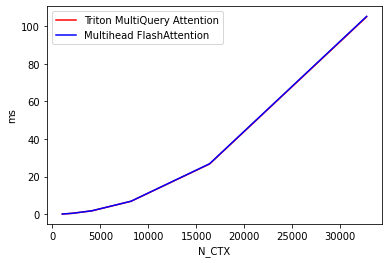

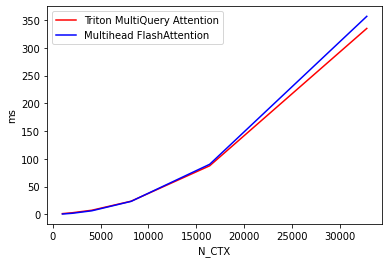

In [5]:
bench_flash_multiquery_attention.run(save_path='.', print_data=True)

## QueryNorm

QueryNorm is a custom norm operation similar to LN but with weights and bias scalars per head instead of per d_head element. This is to be applied to the queries of a multihead/query attention block. The following blocks compare the a triton implementation of this norm with a standard pytorch implementation

In [6]:
def test_querynorm_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float32):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-6
    # naive torch implementation
    naive_out = naive_query_norm(q, w, b, eps)
    # triton implementation
    tri_out = fused_query_norm(q, w.flatten(), b.flatten(), eps)
    tri_out.backward(dy, retain_graph=True)
    dq_tri, dw_tri, db_tri = [_.grad.clone() for _ in [q, w, b]]
    q.grad, w.grad, b.grad = None, None, None
    # backward pass (torch)
    naive_out.backward(dy, retain_graph=True)
    dq_ref, dw_ref, db_ref = [_.grad.clone() for _ in [q, w, b]]
    # compare
    triton.testing.assert_almost_equal(naive_out, tri_out)
    triton.testing.assert_almost_equal(dq_tri, dq_ref)
    triton.testing.assert_almost_equal(db_tri, db_ref)
    triton.testing.assert_almost_equal(dw_tri, dw_ref)
    print("Passed all equality checks")

In [7]:
test_querynorm_op(3, 2, 2048, 64)

Passed all equality checks


In [8]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
configs = [triton.testing.Benchmark(
    x_names=['D_HEAD'],
    x_vals=[512 * i for i in range(2, 16)],
    line_arg='provider',
    line_vals=['triton', 'torch'],
    line_names=['Triton QueryNorm', 'Torch QueryNorm'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name=f'query-norm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'N_CTX': N_CTX, 'dtype': torch.float16, 'mode': mode}
) for mode in ['forward', 'backward']]

@triton.testing.perf_report(configs)
def bench_query_norm(BATCH, H, N_CTX, D_HEAD, dtype, provider, mode='forward', eps=1e-5, device='cuda'):
    # create data
    q_shape = (BATCH, H, N_CTX, D_HEAD)
    w_shape = (1,H,1,1)
    w = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    q = torch.randn(q_shape, dtype=dtype, device='cuda')
    q.requires_grad_(True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-5
    # utility functions
    if provider == 'triton':
        y_fwd = lambda: fused_query_norm(q, w.flatten(), b.flatten(), eps)
    if provider == 'torch':
        y_fwd = lambda: naive_query_norm(q, w, b, eps)
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * q.numel() * q.element_size() / ms * 1e-6
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, rep=500)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * q.numel() * q.element_size() / ms * 1e-6
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True),
                                                     grad_to_none=[q], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

query-norm-forward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1377.289009       185.042813
1   1536.0       1370.090626       187.245714
2   2048.0       1389.455824       187.871945
3   2560.0       1382.616033       188.394015
4   3072.0       1379.705277       189.228105
5   3584.0       1379.705224       189.540832
6   4096.0       1380.310729       187.346088
7   4608.0       1394.382978       190.245344
8   5120.0       1387.984509       190.622458
9   5632.0       1383.235022       186.229912
10  6144.0       1382.535049       190.311855
11  6656.0       1382.316933       187.067549
12  7168.0       1381.089785       190.570984
13  7680.0       1332.935613       190.616290
query-norm-backward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1172.612353        99.657683
1   1536.0       1119.918959       100.219300
2   2048.0       1260.307658       100.626805
3   2560.0       1232.394453       100.580471
4   3072.0       1286.420941       100.

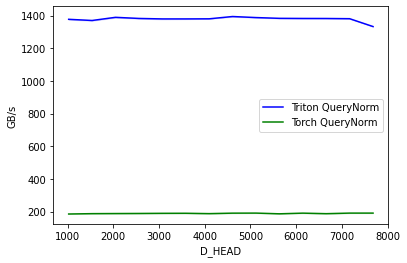

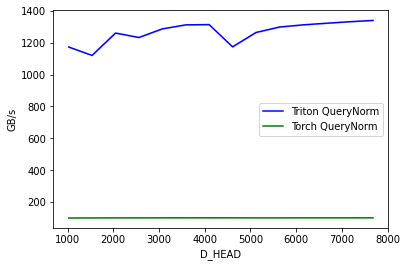

In [9]:
bench_query_norm.run(save_path='.', print_data=True)

## Fusing Multiquery Attention With QueryNorm

We can also fuse multiquery attention with query norm to avoid launching two seperate kernels. The following block compares a fused multiquery attention + QueryNorm kernel with a baseline of composing the two triton kernels we saw previously

In [10]:
def test_multiquery_querynorm_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float16):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    eps = 1e-6
    # triton implementation
    tri_out = multiquery_querynorm_flash_attention(q, k, v, w, b, eps)
    # reference implementation
    ref_out = multiquery_flash_attention(fused_query_norm(q, w, b, eps),k,v)
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)
    print("Passed all equality checks")

In [11]:
test_multiquery_querynorm_op(3, 2, 2048, 64)

Passed all equality checks


In [12]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['fused_multiquery_querynorm','unfused_multiquery_querynorm'],
    line_names=['Fused Multiquery QueryNorm','Unfused Multiquery QueryNorm'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'fused_multiquery_querynorm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd','bwd']]


@triton.testing.perf_report(configs)
def bench_multiquery_querynorm_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    eps = 1e-6
    if provider == "fused_multiquery_querynorm":
        fn = lambda: multiquery_querynorm_flash_attention(q, k, v, w, b, eps)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "unfused_multiquery_querynorm":
        fn = lambda: multiquery_flash_attention(fused_query_norm(q, w, b, eps),k,v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms

fused_multiquery_querynorm-fwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    0.182456                      0.247380
1   2048.0                    0.547302                      0.682853
2   4096.0                    1.878154                      2.151714
3   8192.0                    6.973002                      7.517577
4  16384.0                   26.753708                     27.912535
5  32768.0                  105.159683                    107.512833
fused_multiquery_querynorm-bwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    1.482096                      1.481092
1   2048.0                    3.234885                      3.223654
2   4096.0                    8.208896                      8.148139
3   8192.0                   25.395882                     25.331030
4  16384.0                   91.473923                     91.674622
5  32768.0                  348.793854 

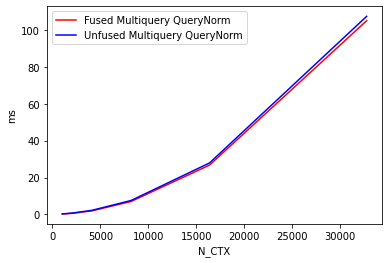

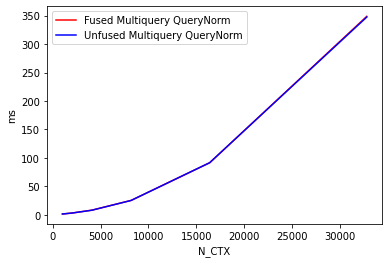

In [13]:
bench_multiquery_querynorm_attention.run(save_path='.', print_data=True)